# ASTR 19 Final Project

Name: Shayna Kaplan

## Step 5-6: Redo Tutorial with f105w Band Image

Import libraries and set up.

In [1]:
%matplotlib inline
import numpy as np
import sep as sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = [10., 8.]

Import matplotlib style guide.

In [2]:
plt.style.use("Downloads/astr19_matplotlib_defaults.txt")

In [3]:
#read the f105w band image into standard 2-d numpy array
data = fits.open("Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
image_data = fits.getdata("Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits", ext=0)

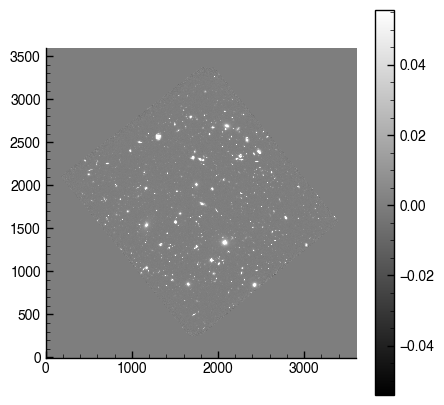

In [4]:
#show the image
m, s = np.mean(image_data), np.std(image_data)
plt.figure(figsize=(5,5))
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

### Background subtraction

In [5]:
#measure a spatially varying background on the image

#converting data to be readable
image_data = image_data.byteswap().newbyteorder()

bkg = sep.Background(image_data)

In [6]:
#get a 'global' mean and noise of the image background
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [7]:
#evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

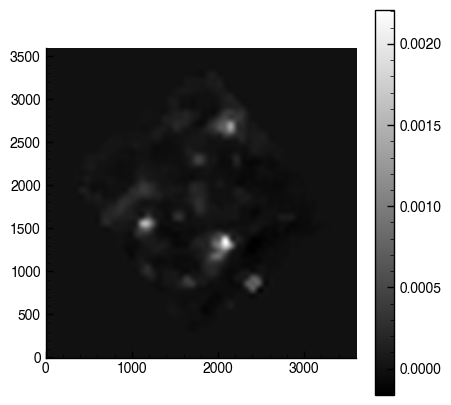

In [8]:
#show the background
plt.figure(figsize=(5,5))
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [9]:
#evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

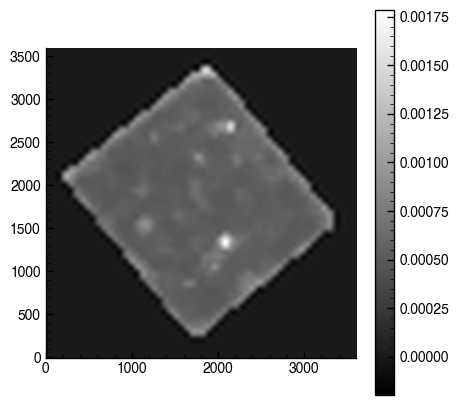

In [10]:
#show the background noise
plt.figure(figsize=(5,5))
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [11]:
#subtract the background
data_sub = image_data - bkg

### Object detection

In [12]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [13]:
#how many objects were detected
len(objects)

8640

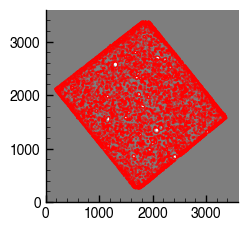

In [14]:
from matplotlib.patches import Ellipse

#plot a background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range (len(objects)):
    e = Ellipse(xy = (objects['x'][i], objects['y'][i]),
               width=6*objects['a'][i],
               height=6*objects['b'][i],
               angle=objects['theta'][i] * 180./np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [15]:
#available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

### Aperture photometry

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [17]:
#show the first 10 objects results
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


### Histogramming the sources

In the following histogram, the y-axis is reduced to show the outliers.

Text(0, 0.5, 'Number of fluxes')

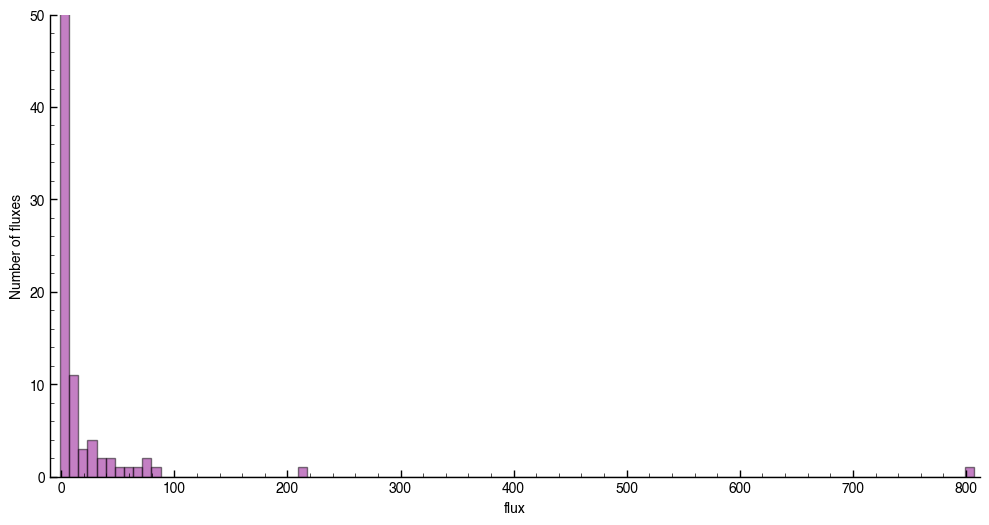

In [18]:
#make a figure
f = plt.figure(figsize=(12,6))
max = np.max(flux)

#plot the histogram
plt.hist(flux,bins=100, color='darkmagenta', alpha=0.5, edgecolor="black")
plt.xlim([-10, max+5])
plt.ylim([0, 50])
plt.xlabel("flux")
plt.ylabel("Number of fluxes")

In this histogram, the y-axis is fully extended. As a result, it is difficult to see the outliers.

Text(0, 0.5, 'Number of fluxes')

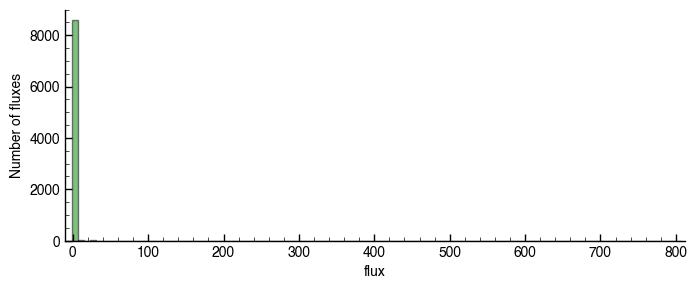

In [19]:
#make a figure
f = plt.figure(figsize=(8,3))
max = np.max(flux)

#plot the histogram
plt.hist(flux,bins=100, color='green', alpha=0.5, edgecolor="black")
plt.xlim([-10, max+5])
plt.ylim([0, 9000])
plt.xlabel("flux")
plt.ylabel("Number of fluxes")

## Step 7: Statistical Analysis of Fluxes.

#### Mean, median, and standard deviation of the fluxes.

In [20]:
flux_mean = np.mean(flux)
flux_med = np.median(flux)
flux_std = np.std(flux)

print(f"The mean of the distribution of fluxes is {flux_mean:.4f}.")
print(f"The median of the distribution of fluxes is {flux_med:.4f}.")
print(f"The standard deviation of the distribution of fluxes is {flux_std:.4f}.")

The mean of the distribution of fluxes is 0.3619.
The median of the distribution of fluxes is 0.0310.
The standard deviation of the distribution of fluxes is 9.2435.


#### Largest outlier of the distribution.

In [21]:
flux_max = np.max(flux)
print(f'The largest outlier is {flux_max:.3f}')

The largest outlier is 807.297


The high standard deviation indicates that the data is spread out. As a result, the mean is higher than the median because the data's average point is pulled towards the high outliers.

#### Where the outlier is on the image.

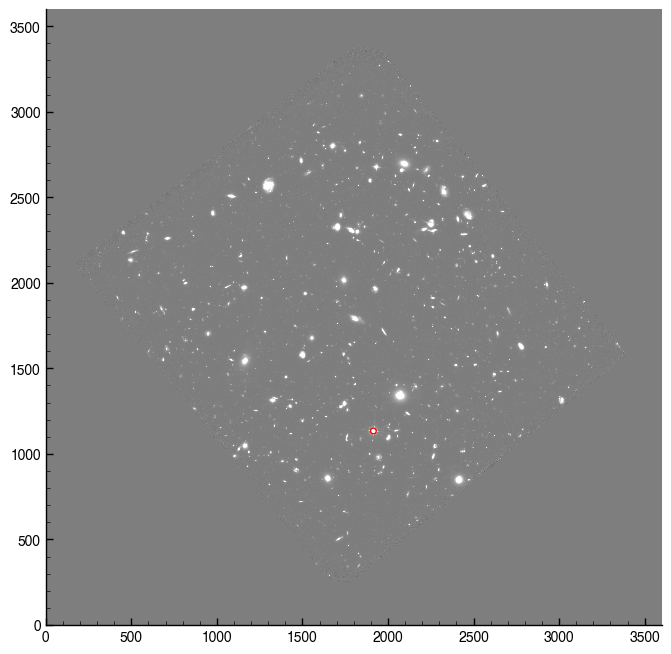

In [22]:
#adapting the object detection code from the sep tutorial

#plot background-subtracted image
fig, ax = plt.subplots(figsize=(8,8))
m, s = np.mean(data_sub), np.std(data_sub)
im = plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    if (flux[i]==flux_max):
        e.set_edgecolor('red')
    ax.add_artist(e)

#### How many standard deviations the outlier is away from the mean..

In [23]:
#use the ratio N = x/sigma, where x=event and sigma=std
N = flux_max / flux_std
print(f'The outlier is {N:.3f} standard deviations away from the mean.')

The outlier is 87.336 standard deviations away from the mean.


## Step 8: Make 3-color False Image with Other Band Images

In [24]:
#define file names
fdata_f105w = "Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
fdata_f125w = "Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_f160w = "Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

#read in data
hdu_2 = fits.open(fdata_f105w)
hdu_3 = fits.open(fdata_f125w)
hdu_4 = fits.open(fdata_f160w)

#get the image data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

In [25]:
#rescale the image data to see faint objects
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m*100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

In [26]:
#plot the rescaled data
def fits_quicklook(data, fnx=10, fny=10):
    f = plt.figure(figsize=(fnx, fny))
    pdata_tmp, vpmin, vpmax = rescale_image(data)
    plt.imshow(pdata_tmp, vmin=vpmin, vmax=vpmax)

In [27]:
#making 3-color image, using the rescaled images
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

In [28]:
#limit data to be between the min and nax vaues in the rescaling
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d2max] = d3max
data_4_res[data_4_res<d4min] = d4min
data_4_res[data_4_res>d2max] = d4max

In [29]:
#create an RGB image
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1],3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


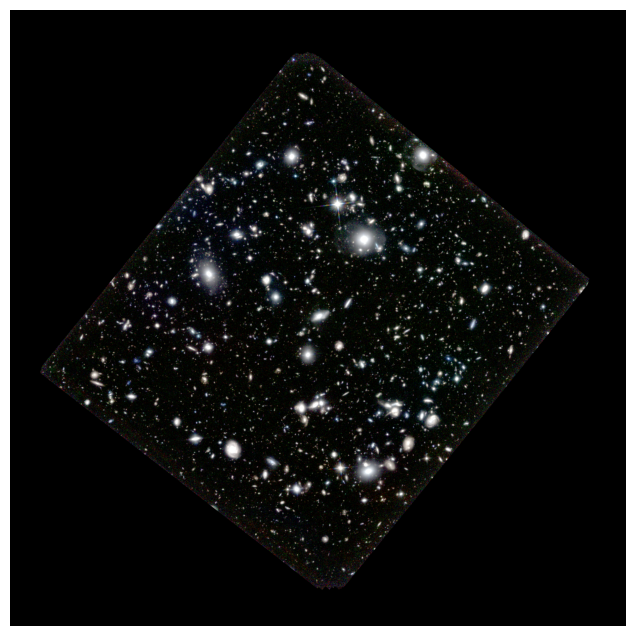

In [30]:
#plot the RGB image
f, ax = plt.subplots(1, 1, figsize=(8,8))
ax.axis('off')
ax.imshow(rgb)
#save the figure as a PNG
plt.savefig('3color-image.png', bbox_inches='tight', pad_inches=0, dpi=600)